In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate

import xarray as xr
import dask.array as da
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches # for creating legend
import matplotlib.dates as mdates # converts datetime64 to datetime

import cartopy
import cartopy.crs as ccrs # for plotting
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point # for wrapping map fully - avoiding white line on 0 deg
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.dates as mdates # converts datetime64 to datetime
import matplotlib.gridspec as gridspec # to create grid-shaped combos of axes
from mpl_toolkits import mplot3d # 3d plotting tool
import cmocean # for nice oceanography colour pallettes

#import argopy
#from argopy import DataFetcher as ArgoDataFetcher # to load Argo ds directly

import os # for finding files

import gsw # for conversion functions

from tqdm.notebook import tqdm_notebook as tqdm
import glob # for downloading data
import sys # for path to functions

import seaborn as sns

sns.set(#font='Helvetica',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'w', 
                            # '#aeaeae',
         'axes.grid': False,
         'axes.labelcolor': 'k',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1)
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["axes.titlesize"] = 22
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["font.size"] = 18
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams["ytick.labelright"] = False

from warnings import filterwarnings as fw
fw('ignore')

# import my own funcs
import sys
sys.path.append('/home/theospira/notebooks/projects/01-WW_climatology/functions')
from plot_formatting import circular_boundary,plot_nice_box
from inspection_funcs import boxplot

import importlib
#importlib.reload(sys.modules['inspection_plot'])

In [2]:
from matplotlib.dates import AutoDateLocator

sys.path.append('/home/theospira/notebooks/projects/03-WW-timeseries/funcs')
from plotting import *
from computations import *
from import_data import *

# load data

In [3]:
d_path='/home/theospira/notebooks/projects/03-WW-timeseries/data/hydrographic_profiles/'
ds = xr.open_dataset(d_path+'gridded-timeseries-ww-recalc1.nc')

In [4]:
def anom_and_mean_profile(ds, v, run_mask_data=1, compute_profile=1, monthly=0):
    """
    Compute mean and anomaly profiles for a specified variable.

    This function calculates the mean and anomaly profiles of a variable across latitude and longitude,
    potentially applying a data mask before computation. The latitude range is restricted to (-79, -50)
    by default.

    Parameters
    ----------
    ds : xarray.Dataset
        The input dataset containing the variable of interest and associated data.
        
    v : str
        The name of the variable for which mean and anomaly profiles are calculated.
        
    run_mask_data : bool, optional
        Whether to apply a data mask using `mask_data` to filter the dataset. Default is True.
        
    compute_profile : bool, optional
        Whether to compute the mean profile (`mn_t`) in addition to the anomaly profile. Default is True.

    Returns
    -------
    tuple of xarray.DataArray or xarray.DataArray
        - If `compute_profile` is True:
            - mn_t : Mean profile of the variable, averaged over latitude, longitude, and time.
            - mn : Anomaly profile of the variable, averaged over latitude and longitude.
        - If `compute_profile` is False:
            - mn : Anomaly profile of the variable, averaged over latitude and longitude.
    """

    
    if run_mask_data:
        ds = mask_data(ds[['ww_ct','ww_type',v]])
    
    ds = ds.sel(lat=slice(-79,-50))
    
    ds = calc_mean_var(ds,v)
    ds[v+'_anm'] = (ds[v]-ds[v+'_mn'])
    
    # compute means 
    mn  = ds[[v,v+'_mn',v+'_anm']]#.where(ds.ww_type>0)
    mn  = mn.mean(('lat','lon'))
    std = ds[v].std(('lat','lon'))
    
    # compute anomaly profiles
    if compute_profile:
        mn_t = ds[v]#.where(ds.ww_type>0)
        if monthly:
            mn_t = mn_t.groupby('time.month').mean('time').mean(('lat','lon'))
        else:
            mn_t = mn_t.mean(('lat','lon','time'))
    
        return mn_t, mn, std

    return mn,std

In [5]:
mn_t,mn,std = [],[],[]
for v in tqdm(['n2','ctemp','asal',]):#'n2_avg']):
    tmp=anom_and_mean_profile(ds,v)
    mn_t+=tmp[0],
    mn+=tmp[1],
    std+=tmp[2],
    del(tmp)

mn_t = xr.merge(mn_t)
mn = xr.merge(mn)
std = xr.merge(std)

  0%|          | 0/3 [00:00<?, ?it/s]

contains ww_ct
contains ww_ct
contains ww_ct


In [7]:
tmp = mask_data(ds[['ww_ct','up_bd','lw_bd','mlp']])
tmp = tmp[['up_bd','lw_bd','mlp']].mean(('lat','lon'))

#mlp = mask_data(ds[['ww_ct','mlp']])
#mlp = mlp.mlp.mean(('lat','lon'))

contains ww_ct


In [8]:
# compute stratification between ML and ocean interior, using sigma (not rho)
g = 9.8
rho0 = 25

ds['ml_in_n2'] = g/rho0*(ds.sig.where(ds.pres < ds.lw_bd).mean('pres') - ds.sig.sel(pres=slice(0,300)
                    ).where(ds.pres > ds.lw_bd).mean('pres')) / (ds.lw_bd/2 - ((ds.lw_bd + (300-ds.lw_bd)/2)))

ml_in_n2 = mask_data(ds[['ww_ct','ml_in_n2',]])
ml_in_n2 = ml_in_n2[['ml_in_n2']]
ml_in_n2 = calc_mean_var(ml_in_n2,'ml_in_n2')
ml_in_n2['anm'] = ml_in_n2['ml_in_n2'] - ml_in_n2['ml_in_n2_mn']

contains ww_ct


In [9]:
si = load_sea_ice()
si = si.sel(lat=slice(-80,-52)).sel(time=slice('2005-01-01','2022-01-01'))
si = calc_mean_var(si,'sia')
si = calc_mean_var(si,'sic')

# compute sia_anm
si['sia_anm'] = si.sia - si.sia_mn

# plotting funcs

In [10]:
def line_plot_anom_vertical_sections(ax, dsvar, ds_ww, ticks_in=1, bbox_to_anchor=(1.0, .9), fs=15, add_leg=1,
                                     ocean_int_lb=200, **leg_kwargs):
    """
    Plot anomaly vertical sections for different ocean layers.

    This function creates a time series plot of anomalies averaged over specific vertical 
    ocean layers: summer mixed layer (ML), winter water (WW), and ocean interior. The function 
    allows customization of the appearance and legend.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object on which to plot the time series.

    dsvar : xarray.DataArray
        The data array containing the variable to plot with dimensions including 'time' and 'pres'.

    ds_ww : xarray.Dataset
        Dataset containing boundaries for different water layers:
        - `up_bd`: Upper boundary of the winter water.
        - `lw_bd`: Lower boundary of the winter water.

    ticks_in : bool, optional
        Whether to position x-axis ticks inside the plot. Default is 1 (True).

    bbox_to_anchor : tuple, optional
        The legend's position relative to the axes. Default is (1.0, .9).

    fs : int, optional
        Font size for the legend. Default is 15.

    add_leg : bool, optional
        Whether to add a legend to the plot. Default is 1 (True).

    ocean_int_lb : float, optional
        Lower boundary for the ocean interior layer. Default is 200.

    **leg_kwargs : dict
        Additional keyword arguments passed to the legend function.

    Returns
    -------
    None
        The function directly modifies the provided axes with the plot.
    """


    kwargs=dict(x='time',ax=ax,alpha=0.8,)
    dsvar.where(dsvar.pres<ds_ww.up_bd).mean('pres'
            ).plot(**kwargs,label='summer ML',c='#e41a1c',zorder=2,lw=2.5)
    dsvar.where((dsvar.pres>ds_ww.up_bd) & (dsvar.pres<ds_ww.lw_bd)).mean('pres'
            ).plot(**kwargs,label='WW',c='#377eb8',zorder=3,lw=3)
    dsvar.where((dsvar.pres>ds_ww.lw_bd) & (dsvar.pres <= ocean_int_lb)).mean('pres'
            ).plot(**kwargs,label='ocean interior',c='#ff7f00',zorder=1,lw=2.5)
    
    #a.set_ylim(-5e-6,5e-6)
    ax.axhline(0,ls='--',c='darkgrey',zorder=0)

    if ticks_in:
        ax.tick_params(axis="x",direction="in", left="off",labelleft="off",which='both')
    si_timeseries_plot_formatting(ax=ax,lw=3)
    ax.set_ylabel('')
    #ax.set_xticklabels('')

    # add legend
    if add_leg:
        leg = ax.legend(loc='lower right',bbox_to_anchor=bbox_to_anchor,ncol=3,columnspacing=0.8,fontsize=fs)
        leg.get_frame().set_facecolor('none')
        leg.get_frame().set_linewidth(0)

In [11]:
def line_plot_anom_vertical_sections_rolling_mean(ax, dsvar, ds_ww, ticks_in=1, bbox_to_anchor=(1.0, .9), fs=15, 
                                                  add_leg=1, rolling_mn=11, ocean_int_lb=200, **leg_kwargs):
    """
    Plot rolling mean anomaly vertical sections for different ocean layers.

    This function creates a time series plot of rolling mean anomalies averaged over 
    specific vertical ocean layers: summer mixed layer (ML), winter water (WW), and ocean 
    interior. The rolling mean helps smooth temporal variability.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object on which to plot the time series.

    dsvar : xarray.DataArray
        The data array containing the variable to plot with dimensions including 'time' and 'pres'.

    ds_ww : xarray.Dataset
        Dataset containing boundaries for different water layers:
        - `up_bd`: Upper boundary of the winter water.
        - `lw_bd`: Lower boundary of the winter water.

    ticks_in : bool, optional
        Whether to position x-axis ticks inside the plot. Default is 1 (True).

    bbox_to_anchor : tuple, optional
        The legend's position relative to the axes. Default is (1.0, .9).

    fs : int, optional
        Font size for the legend. Default is 15.

    add_leg : bool, optional
        Whether to add a legend to the plot. Default is 1 (True).

    rolling_mn : int, optional
        Rolling mean window size (in months). Default is 11.

    ocean_int_lb : float, optional
        Lower boundary for the ocean interior layer. Default is 200.

    **leg_kwargs : dict
        Additional keyword arguments passed to the legend function.

    Returns
    -------
    None
        The function directly modifies the provided axes with the plot.
    """


    kwargs=dict(x='time',ax=ax,alpha=0.8,)
    dsvar.where(dsvar.pres<ds_ww.up_bd).mean('pres').rolling({'time':rolling_mn},min_periods=1).mean(
            ).plot(**kwargs,label='summer ML',c='#e41a1c',zorder=2,lw=3)
    dsvar.where((dsvar.pres>ds_ww.up_bd) & (dsvar.pres<ds_ww.lw_bd)).mean('pres').rolling({'time':rolling_mn},min_periods=1).mean(
            ).plot(**kwargs,label='WW',c='#377eb8',zorder=3,lw=4)
    dsvar.where((dsvar.pres>ds_ww.lw_bd) & (dsvar.pres <= ocean_int_lb)).mean('pres').rolling({'time':rolling_mn},min_periods=1).mean(
            ).plot(**kwargs,label='ocean interior',c='#ff7f00',zorder=1,lw=3)
    
    #ax.axhline(0,ls='--',c='darkgrey',zorder=0)

    if ticks_in:
        ax.tick_params(axis="x",direction="in", left="off",labelleft="off",which='both')
    si_timeseries_plot_formatting(ax=ax,lw=3)
    ax.set_ylabel('')
    #ax.set_xticklabels('')

    # add legend
    if add_leg:
        leg = ax.legend(loc='lower right',bbox_to_anchor=bbox_to_anchor,ncol=3,columnspacing=0.8,fontsize=fs)
        leg.get_frame().set_facecolor('none')
        leg.get_frame().set_linewidth(0)

In [12]:
def n2_line_plot_anom_ww_sections_rolling_mean(ax, dsvar, ds_ww, c_ml_in = None, ticks_in=1, bbox_to_anchor=(1.0, .9), fs=15, 
                                               add_leg=1, rolling_mn=11, ocean_int_lb=200, **leg_kwargs):
    """
    Plot rolling mean anomalies for boundaries of winter water (WW).
    Written with the intention of plotting stratification.

    This function creates a time series plot of rolling mean anomalies averaged over 
    narrow depth bands near the boundaries of winter water:
    - Mixed Layer–Winter Water (ML–WW) boundary.
    - Winter Water–Ocean Interior (WW–OI) boundary.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object on which to plot the time series.

    dsvar : xarray.DataArray
        The data array containing the variable to plot with dimensions including 'time' and 'pres'.

    ds_ww : xarray.Dataset
        Dataset containing boundaries for different water layers:
        - `up_bd`: Upper boundary of the winter water.
        - `lw_bd`: Lower boundary of the winter water.

    ticks_in : bool, optional
        Whether to position x-axis ticks inside the plot. Default is 1 (True).

    bbox_to_anchor : tuple, optional
        The legend's position relative to the axes. Default is (1.0, .9).

    fs : int, optional
        Font size for the legend. Default is 15.

    add_leg : bool, optional
        Whether to add a legend to the plot. Default is 1 (True).

    rolling_mn : int, optional
        Rolling mean window size (in months). Default is 11.

    ocean_int_lb : float, optional
        Lower boundary for the ocean interior layer. Default is 200.

    **leg_kwargs : dict
        Additional keyword arguments passed to the legend function.

    Returns
    -------
    None
        The function directly modifies the provided axes with the plot.
    """


    kwargs=dict(x='time',ax=ax,alpha=0.8,)
    #dsvar.where(dsvar.pres<ds_ww.up_bd).mean('pres').rolling({'time':rolling_mn},min_periods=1).mean(
     #       ).plot(**kwargs,label='summer ML',c='#e41a1c',zorder=2,lw=3)
    dsvar.where((dsvar.pres>=ds_ww.up_bd - 10) & (dsvar.pres<=ds_ww.up_bd + 10)).mean('pres').rolling({'time':rolling_mn},min_periods=1).mean(
            ).plot(**kwargs,label='ML–Winter Water',c='#B8377E',zorder=3,lw=4)
    dsvar.where((dsvar.pres>=ds_ww.lw_bd - 10) & (dsvar.pres<=ds_ww.lw_bd + 10)).mean('pres').rolling({'time':rolling_mn},min_periods=1).mean(
            ).plot(**kwargs,label='WW–ocean interior',c='#699a2e',zorder=1,lw=4)

    if c_ml_in is not None:
        ax.plot([],[],c=c_ml_in,ls='-.',label='ML–ocean interior',lw=3.3,) #alpha=0.8)
    
    #ax.axhline(0,ls='--',c='darkgrey',zorder=0)

    if ticks_in:
        ax.tick_params(axis="x",direction="in", left="off",labelleft="off",which='both')
    si_timeseries_plot_formatting(ax=ax,lw=3)
    ax.set_ylabel('')
    #ax.set_xticklabels('')

    # add legend
    if add_leg:
        leg = ax.legend(loc='lower right',bbox_to_anchor=bbox_to_anchor,ncol=3,columnspacing=0.8,fontsize=fs)
        leg.get_frame().set_facecolor('none')
        leg.get_frame().set_linewidth(0)

# plot hovmollers

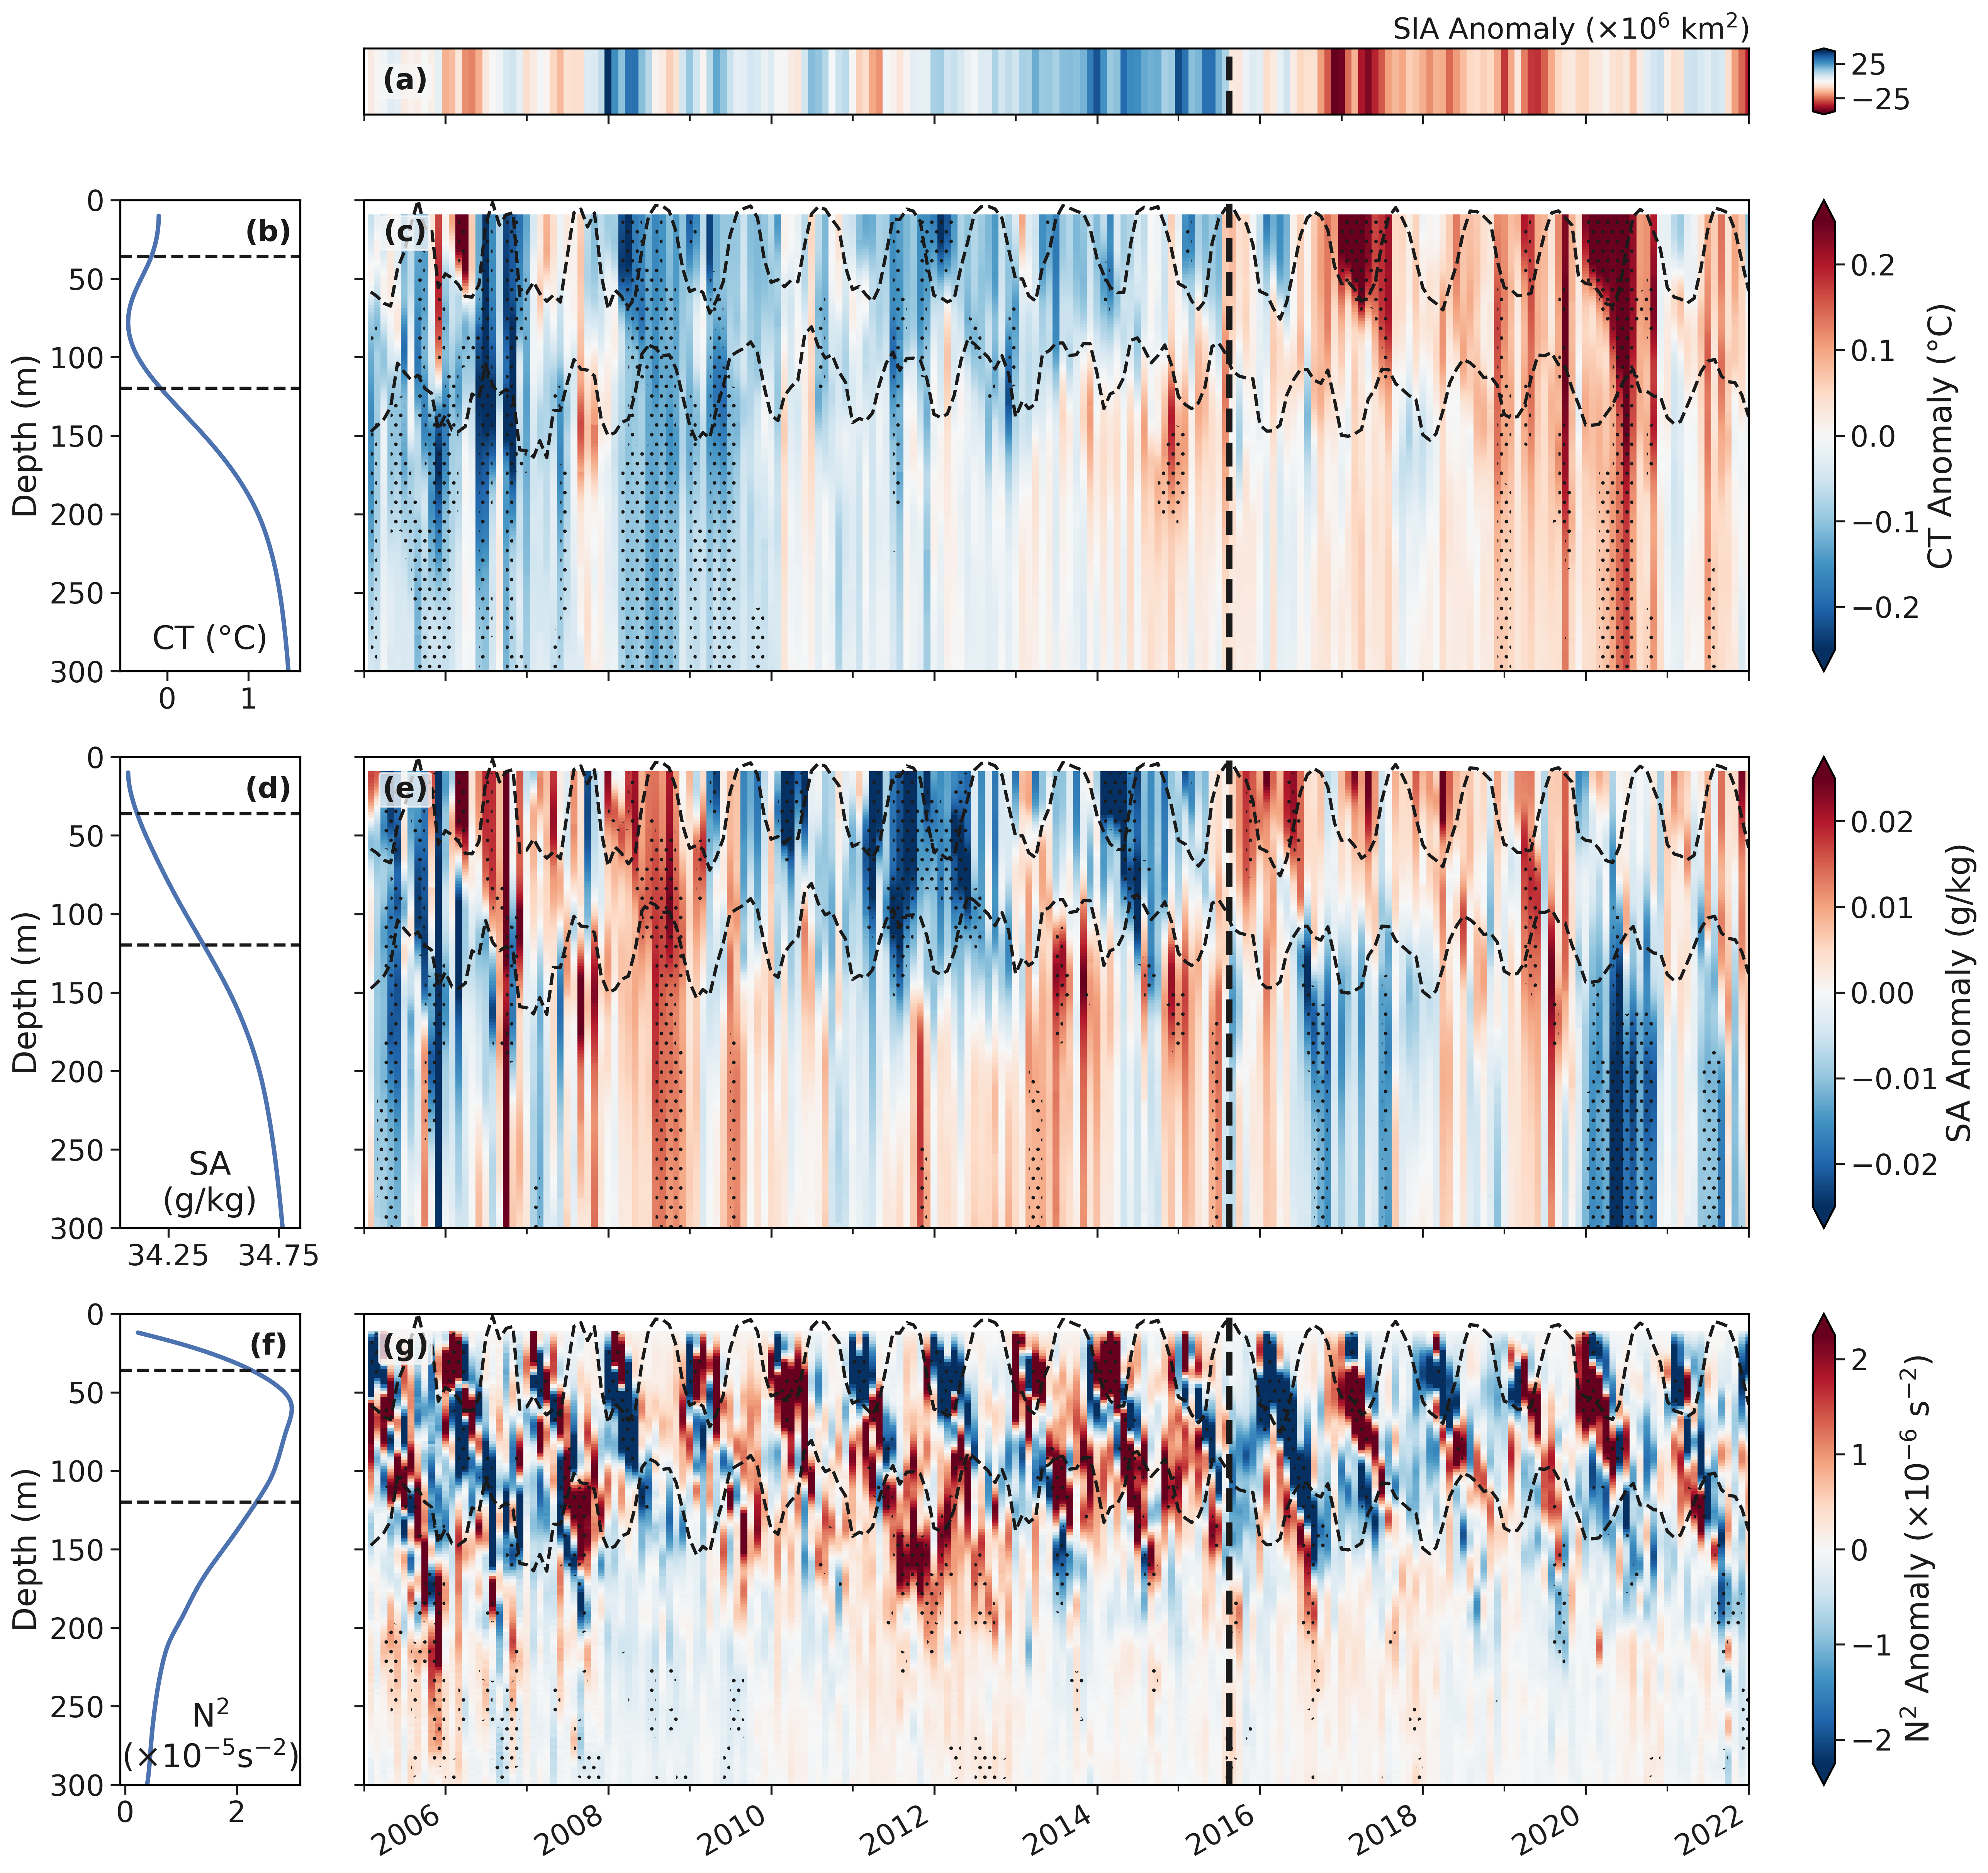

In [33]:
#fig = plt.figure(figsize=(17.5,5*3*1.1),dpi=300)
#gs  = gridspec.GridSpec(5,3, figure=fig, width_ratios=(0.5,5,0.08), height_ratios=(0.1,1,1,0.4,1))
#gs  = gridspec.GridSpec(5,3, figure=fig, width_ratios=(0.5,5,0.08), height_ratios=(0.1,1,1,0.4,1))

fig,ax = plt.subplots(4,3,figsize=(17.5,5*3*1.1),width_ratios=(0.65,5,0.08),
                      height_ratios=(0.14,1,1,1),dpi=300)
ax = ax.flatten()

# define colorbar axes
cax = ax[2::3]
# remove colorbar axes from ax
ax = np.array([ax[i] for i in range(len(ax)) if (i % 3) != 2])

# load cmap
cmap_br = get_cmap()
hmp_kwargs = dict(x='time',cmap=cmap_br,add_colorbar=False)
line_kwargs = dict(y='pres',lw=2.75) #kwargs for the upper and lower bounds in timeseries

# plot climate stripes sea ice area
plot_sea_ice_climate_stripes(si,ax[1],fig,cax=cax[0])

# plot T
# hovmoller
vmax=0.25
hvm = (mn.ctemp_anm).plot(**hmp_kwargs,ax=ax[3],vmin=-vmax,vmax=vmax,)
ctr = ax[3].contourf(mn.time,mn.pres,
                     (mn.ctemp_anm.where(np.abs(mn.ctemp_anm)>mn.ctemp_anm.std('time'))).T,
                     hatches=["..",],colors='none',)
ctr._hatch_color = mcolors.to_rgba('k')
fig.colorbar(hvm,cax=cax[1],label='CT Anomaly (°C)',extend='both')
# profile
(mn_t.ctemp).plot(**line_kwargs,ax=ax[2])
ax[2].set_xlabel('CT (°C)')
ax[2].xaxis.set_label_coords(0.5,0.1)


# plot SA
# hovmoller
vmax=0.025
hvm = (mn.asal_anm).plot(**hmp_kwargs,ax=ax[5],vmin=-vmax,vmax=vmax,)
ctr = ax[5].contourf(mn.time,mn.pres,
                     (mn.asal_anm.where(np.abs(mn.asal_anm)>mn.asal_anm.std('time'))).T,
                     hatches=["..",],colors='none',)
ctr._hatch_color = mcolors.to_rgba('k')
fig.colorbar(hvm,cax=cax[2],label='SA Anomaly (g/kg)',extend='both')
# profile
(mn_t.asal).plot(**line_kwargs,ax=ax[4])
ax[4].set_xlabel('SA\n(g/kg)')
ax[4].xaxis.set_label_coords(0.5,0.165)
ax[4].set_xticks([34.25,34.75])

# plot n2
# hovmoller
vmax=2.25
hvm = (mn.n2_anm*1e6).plot(**hmp_kwargs,ax=ax[7],vmin=-vmax,vmax=vmax,)
ctr = ax[7].contourf(mn.time,mn.pres,
                     (mn.n2_anm.where(np.abs(mn.n2_anm)>mn.n2_anm.std('time'))).T,
                     hatches=["..",],colors='none',)
ctr._hatch_color = mcolors.to_rgba('k')
fig.colorbar(hvm,cax=cax[3],label=r'N$^2$ Anomaly ($\times 10^{-6}$ s$^{-2}$)',extend='both')
# profile
(mn_t.n2*1e5).plot(**line_kwargs,ax=ax[6])
ax[6].set_xlabel('N$^2$\n'r'($\times 10^{-5}$''s$^{-2}$)',)
ax[6].xaxis.set_label_coords(0.5,0.175)

for a,v in zip(ax[3::2],['ctemp','asal','n2']):
    # add WW bounds
    tmp.up_bd.plot(x='time',ax=a,c='k',ls='--',lw=2)
    tmp.lw_bd.plot(x='time',ax=a,c='k',ls='--',lw=2)

    # add stippling
    msk = std[v].median().data * 1.2
    #ctr = a.contourf(std.time,std.pres,std[v].where(std[v]>msk).T, hatches=["..",],colors='none',)
    #ctr._hatch_color = mcolors.to_rgba('k')

for a in ax[1::2]:
    a.set_ylabel('')
    a.set_yticklabels('')
    si_timeseries_plot_formatting(ax=a,lw=4)

for a in ax[2::2]:
    # add bounds of WW
    a.axhline(tmp.up_bd.mean('time'),c='k',ls='--',lw=2.)
    a.axhline(tmp.lw_bd.mean('time'),c='k',ls='--',lw=2.)
    a.set_ylabel('Depth (m)')

for a in ax[2:]:
    a.set_ylim(0,300)
    a.invert_yaxis()

# Remove x-tick labels for all except the last
for i, a in enumerate(ax[1::2]):
    if i < len(ax[1::2]) - 1:  
        a.set_xticklabels([])

fig.delaxes(ax[0])

# add figure labels
fig_labels(0.03,.5,ax=ax[1],j=0,fs=18) # for sea ice time series
# add labels to profiles
for i,a in zip([1,3,5],ax[[2,4,6]]):
    fig_labels(0.825,.93,ax=a,j=i,add_bbox=0,fs=18)
# for time series
for i,a in zip([2,4,6],ax[[3,5,7]]):
    fig_labels(0.03,.93,ax=a,j=i,fs=18)

fig.tight_layout()

### check difference in dbar and m

In [15]:
ds_prof = xr.open_dataset(d_path+'hydrographic_profiles_1.nc')

In [22]:
print('std for each pressure level in z as %age:\n',
      f"{(np.round(100*(ds_prof.z.std('n_prof'))/ds_prof.z.mean('n_prof').data,2).data)}")

std for each pressure level in z as %age:
 [0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.07 0.07 0.07 0.07 0.07 0.07 0.0

In [29]:
print('difference between z (m) and p as %age:\n',
      f"{(np.round(np.abs(100*(ds_prof.z-ds_prof.pres).mean('n_prof')/ds_prof.z.mean('n_prof')).data,2))}")

difference between z (m) and p as %age:
 [0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.91 0.91 0.91
 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91
 0.91 0.91 0.91 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92
 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.93 0.93 0.93 0.93
 0.93 0.93 0.93 0.93 0.93 0.93 0.93 0.93 0.93 0.93 0.93 0.93 0.93 0.93
 0.93 0.93 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94
 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.95 0.95 0.95 0.95 0.95
 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95
 0.95 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96
 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.97 0.97 0.97 0.97 0.97 0.97
 0.97 0.97 0.97 0.97 0.97 0.97 0.97 0.97 0.97 0.97 0.97 0.97 0.97 0.97
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.99 0.99 0.99 0.99 0.99 0.99 0.99
 0.99 0.99 0.99 0.99 0.99 0.99 0.99 

## plot line plots of vertical ocean sections

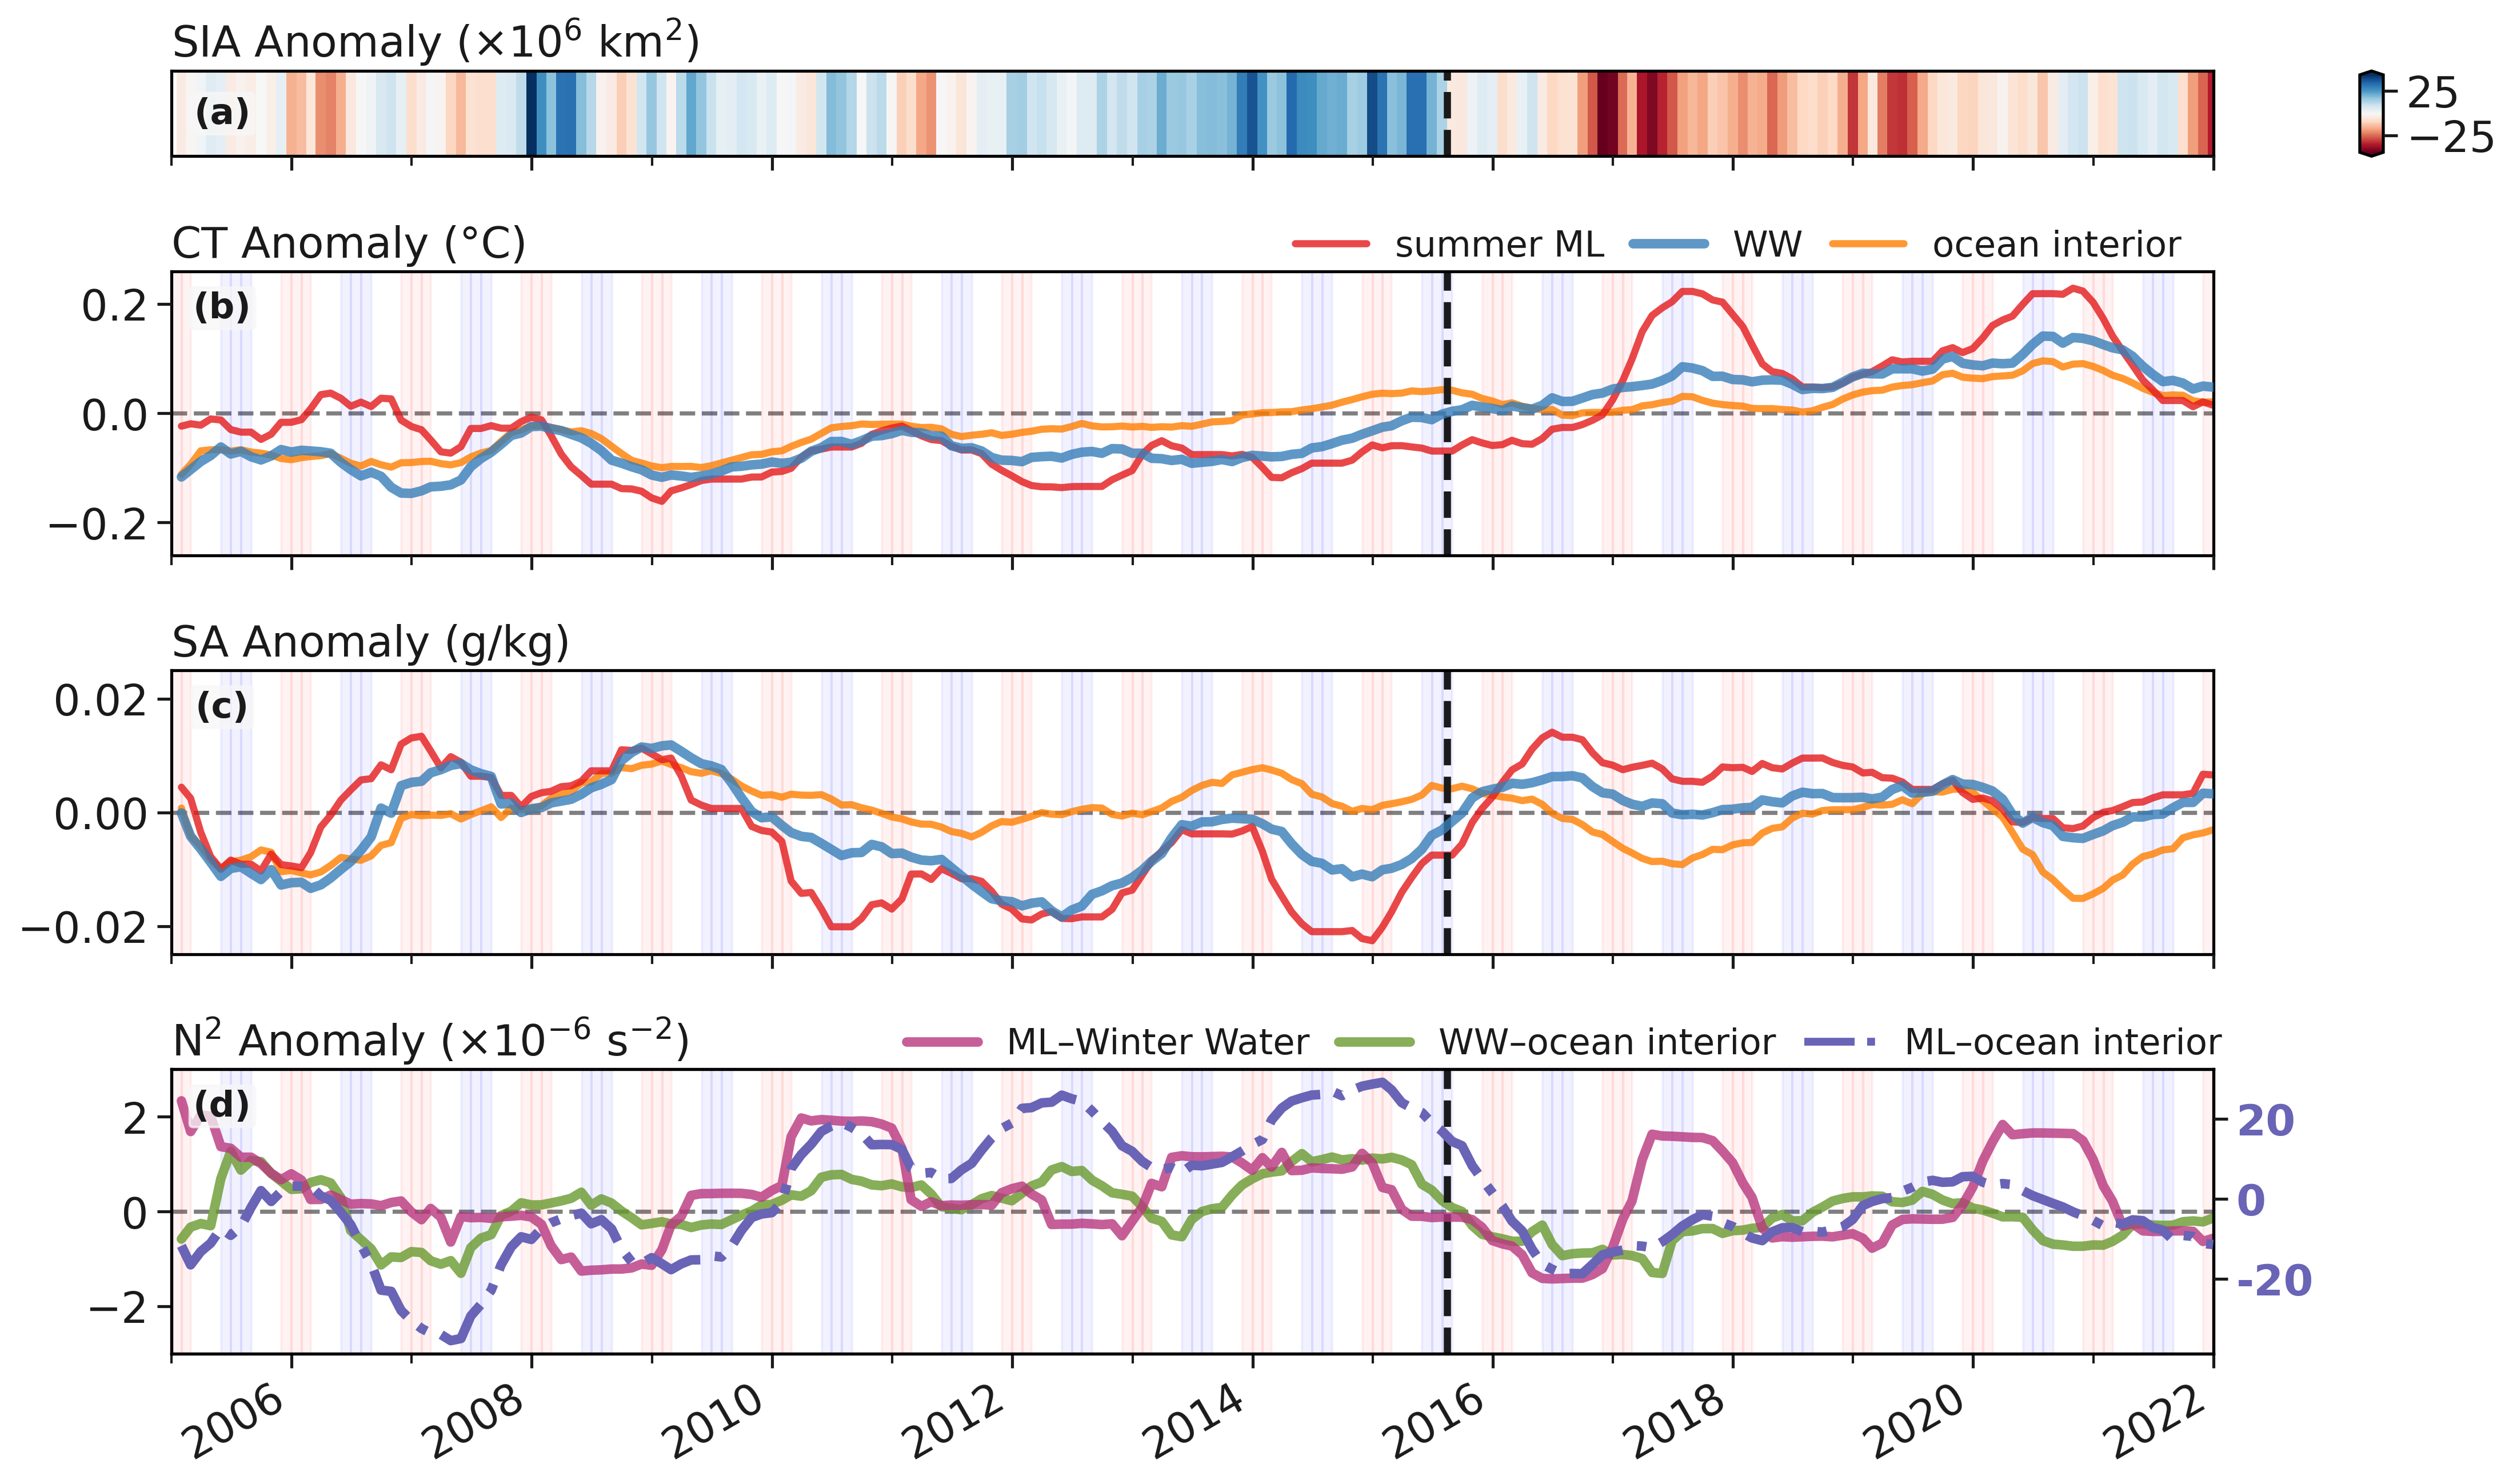

In [31]:
fig,ax = plt.subplots(4,2,figsize=(15,9),sharex='col',height_ratios=[0.3,1,1,1],
                      width_ratios=[1,0.0115],dpi=300)
cax = ax.flatten()[1::2]
ax_lines = ax.flatten()[::2]

plot_sea_ice_climate_stripes(si,ax.flatten()[0],fig,cax=cax[0],title_loc='left')
ax_lines[0].set_xlabel('')
si_timeseries_plot_formatting(ax=ax_lines[0],lw=3)

kwargs = dict(ds_ww=tmp,ticks_in=0,fs=15,rolling_mn=12,ocean_int_lb=300)
c_ml_in = '#6964b6'

for a,v,s,ylim,add_leg in zip(ax_lines[1:],['ctemp','asal','n2'],
            ['CT Anomaly (°C)','SA Anomaly (g/kg)','N$^2$ Anomaly 'r'($\times 10^{-6}$ s$^{-2}$)'],
            [0.26,0.025,3],[1,0,1]):
    if v=='n2':
        n2_line_plot_anom_ww_sections_rolling_mean(a,mn[v+'_anm']*1e6,c_ml_in=c_ml_in,
                                                   add_leg=add_leg,bbox_to_anchor=(1.02,0.915),**kwargs)
    else:
        line_plot_anom_vertical_sections_rolling_mean(a,mn[v+'_anm'],add_leg=add_leg,
                                                      bbox_to_anchor=(1.,0.915),**kwargs)
    a.set_title(s,loc='left',fontsize=18)
    a.set_ylim(-ylim,ylim)

for a,ylines in zip(ax_lines[1:],[[0.2,-0.2],[0.02,-0.02],[2,-2]]):
    a.axhline(0,c='grey',ls='--',lw=1.75,zorder=0)

    plot_with_season_background(mn,alpha=0.05,ax=a)
    #a.set_yticks(np.arange(ylines[0],ylines[1]+ylines[1]/2,ylines[1]/4),minor=1)
    #a.grid(ls='--',c='grey',which='both')

a = ax_lines[-1].twinx()
(ml_in_n2.anm.mean(('lat','lon'))*1e6).rolling({'time':12},min_periods=1).mean(
            ).plot(ax=a,x='time',c=c_ml_in,ls='-.',zorder=10,lw=4,)
a.set_yticks(np.arange(-20,21,20),)
a.set_yticklabels(np.arange(-20,21,20),color=c_ml_in,weight='bold')
a.set_ylabel('')

for a in cax[1:]:
    fig.delaxes(a)

fig_labels(0.025,.5,ax=ax_lines[0],j=0) # for sea ice time series
for i,a in enumerate(ax_lines[1:]):
    fig_labels(0.025,.87,ax=a,j=i+1,add_bbox=1)

fig.tight_layout()

# linear regression plotting

In [52]:
idx = int(np.where(mn.time==np.datetime64('2015-08-31'))[0][0])

In [53]:
# https://github.com/edoddridge/2023-sea-ice-regime/blob/main/ocean_temp_time_series.ipynb
from scipy.stats import linregress

def compute_lin_regression_ds(dsvar):
    """
    Perform ordinary least squares regression at each depth level following the methodology in Purich and Doddridge (2023).

    This function calculates the linear regression slope, standard error, intercept, R-value, and p-value 
    for each depth level in the input dataset `dsvar`. The slopes are converted from degrees per month 
    to degrees per decade.

    Parameters
    ----------
    dsvar : xarray.DataArray
        Dataset containing the variable of interest, with dimensions including `time` and `pres` (depth).

    Returns
    -------
    xarray.Dataset
        A dataset containing the regression results, with variables for the slope, standard error, intercept, 
        R-value, and p-value at each depth level.
    """
    
    # linear regression at every depth level
    slopes = []
    std_err = []
    intercepts = []
    r_values = []
    p_values = []
    
    for i in range (len(dsvar.pres)):
        ols = linregress(np.arange(len(dsvar.time)),dsvar.isel(pres=i))
        slopes.append(ols.slope)
        std_err.append(ols.stderr)
        intercepts.append(ols.intercept)
        r_values.append(ols.rvalue)
        p_values.append(ols.pvalue)
    
    
    #convert slope from degrees per month to degrees per decade
    slopes = np.asarray(slopes)*12
    std_err = np.asarray(std_err)*12
    intercepts = np.asarray(intercepts)
    r_values = np.asarray(r_values)
    p_values = np.asarray(p_values)
    
    ds_ols = xr.Dataset(data_vars={'slope':('pres', slopes),
                                   'std_err':('pres', std_err),
                                   'intercept':('pres', intercepts),
                                   'r_value':('pres', r_values),
                                   'p_value':('pres', p_values)},
                            coords={'pres':mn.pres})
    
    ds_ols.slope.attrs['description'] = 'Yearly trend'
    ds_ols.std_err.attrs['description'] = 'Yearly trend'

    return ds_ols

In [54]:
# https://github.com/edoddridge/2023-sea-ice-regime/blob/main/ocean_temp_time_series.ipynb
from scipy.stats import linregress

def compute_lin_regression_ds_1d(dsvar):
    """
    Perform ordinary least squares regression at each depth level following the methodology in Purich and Doddridge (2023).

    This function calculates the linear regression slope, standard error, intercept, R-value, and p-value 
    for each depth level in the input dataset `dsvar`. The slopes are converted from degrees per month 
    to degrees per decade.

    Parameters
    ----------
    dsvar : xarray.DataArray
        Dataset containing the variable of interest, with dimensions including `time` and `pres` (depth).

    Returns
    -------
    xarray.Dataset
        A dataset containing the regression results, with variables for the slope, standard error, intercept, 
        R-value, and p-value at each depth level.
    """
    
    # linear regression at every depth level
    
    ols = linregress(dsvar)
    #convert slope from degrees per month to degrees per year
    slopes = (ols.slope)*12
    std_err = (ols.stderr)*12
    ## continue
    intercepts = (ols.intercept)
    r_values = (ols.rvalue)
    p_values = (ols.pvalue)
    
    ds_ols = xr.Dataset(data_vars={'slope':(slopes),
                                   'std_err':(std_err),
                                   'intercept':(intercepts),
                                   'r_value':(r_values),
                                   'p_value':(p_values)},
                            #coords={'pres':mn.pres}
                       )
    
    ds_ols.slope.attrs['description'] = 'Yearly trend'
    ds_ols.std_err.attrs['description'] = 'Yearly trend'

    return ds_ols

ctemp  high SIA : p val: 0.0461 and R2: 0.2658
trend sum ML: -0.0043
 trend WW    : 0.0039
 trend oc int: 0.0124

ctemp  low SIA  : p val: 0.0496 and R2:0.10
 trend sum ML: 0.0060
 trend WW    : 0.0095
 trend oc int: 0.0094

asal  high SIA : p val: 0.0666 and R2: 0.0704
trend sum ML: -2.1812
 trend WW    : -0.9765
 trend oc int: 0.8275

asal  low SIA  : p val: 0.1800 and R2:0.06
 trend sum ML: -1.6236
 trend WW    : -0.6311
 trend oc int: -0.5173

n2  high SIA : p val: 0.3133 and R2: 0.0235
trend sum ML: 0.0641
 trend WW    : 0.0911
 trend oc int: 0.0192

n2  low SIA  : p val: 0.2827 and R2:0.05
 trend sum ML: 0.0225
 trend WW    : 0.1389
 trend oc int: -0.0400



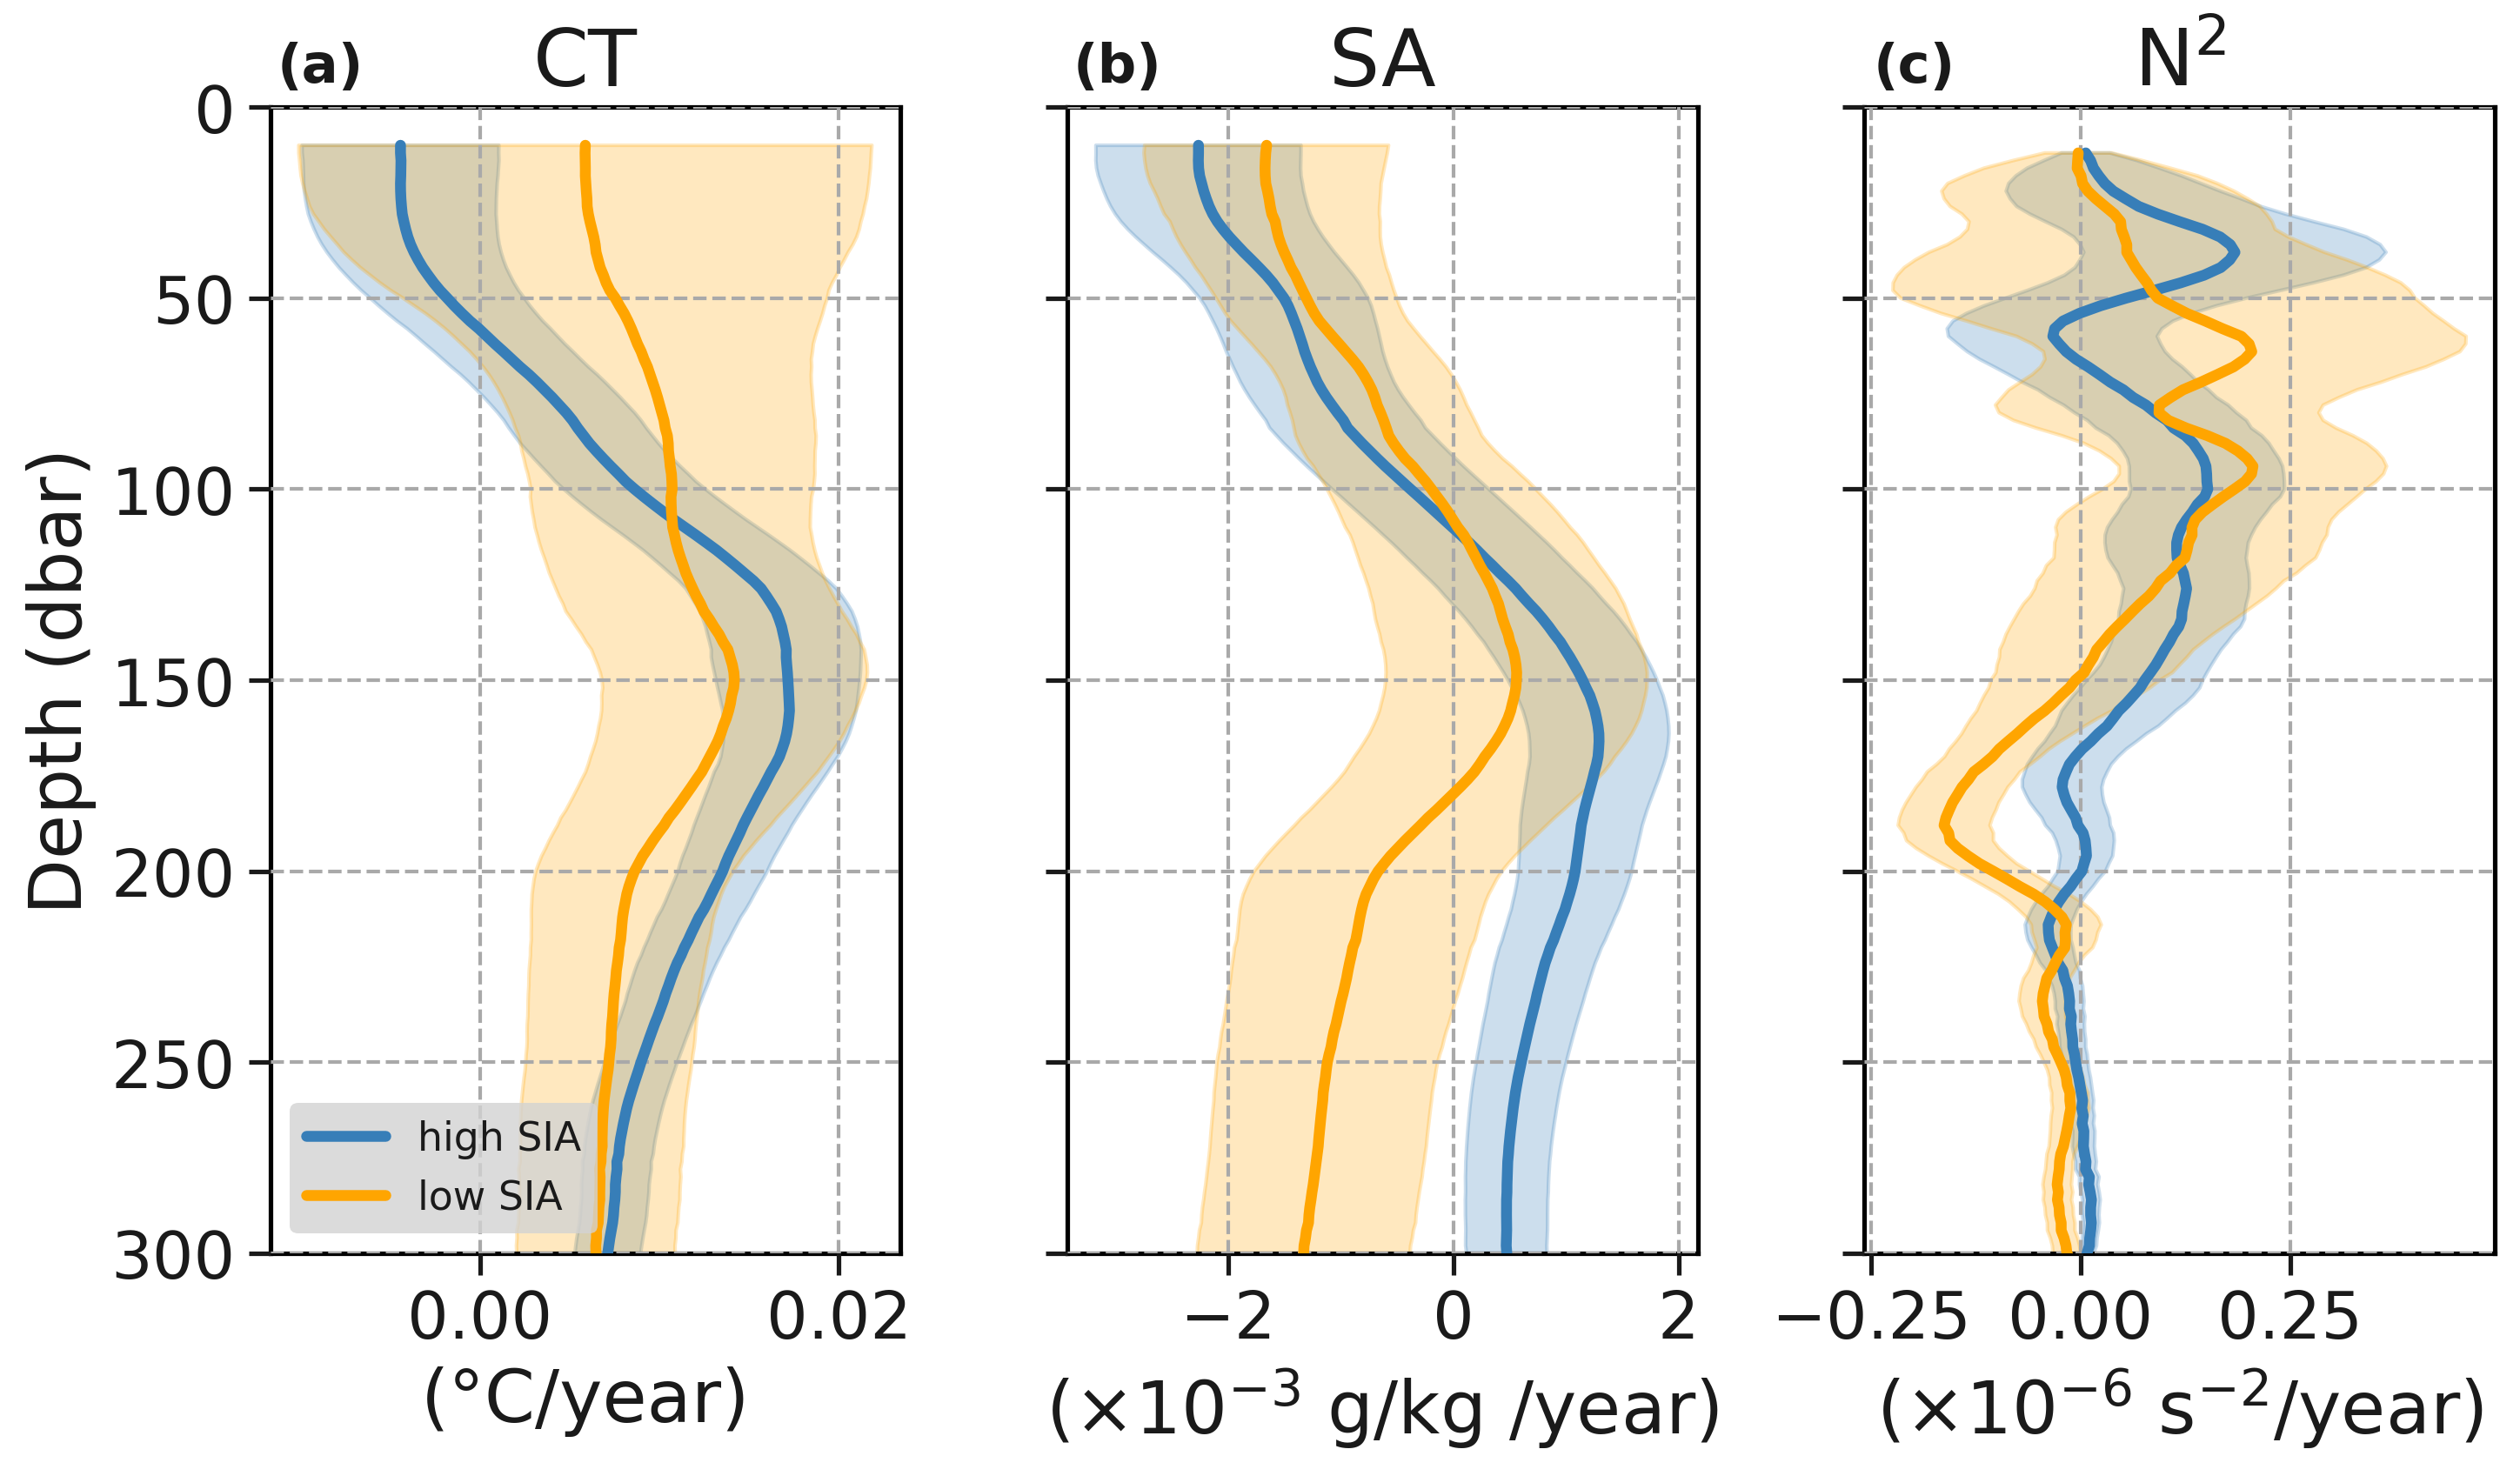

In [97]:
fig,ax = plt.subplots(1,3,sharex=0,sharey=1,figsize=(10,6),dpi=300)
ax = ax.flatten()

l_kwargs = dict(y='pres',yincrease=0,zorder=10,lw=3)

for v,a,t,xlab,multiplier in zip(['ctemp','asal','n2'],ax[:3],['CT','SA','N$^2$'],
        [r'(°C/year)',r'($\times 10^{-3}$ g/kg /year)',r'($\times 10^{-6}$ s$^{-2}$/year)'],
        [1,1e3,1e6]):
    
    ds_ols = compute_lin_regression_ds(mn[v+'_anm'][:idx])
    (ds_ols.slope*multiplier).plot(**l_kwargs,label='high SIA',ax=a,c='#377eb8')
    a.fill_betweenx(ds_ols['pres'],
                    (ds_ols['slope'] - 2*ds_ols['std_err'])*multiplier,
                    (ds_ols['slope'] + 2*ds_ols['std_err'])*multiplier,
                    alpha=0.25, color='#377eb8')

    sum_mean = (ds_ols.slope*multiplier).where(mn.pres < tmp.up_bd[:idx].mean()).mean().values
    ww_mean  = (ds_ols.slope*multiplier).where((mn.pres>tmp.up_bd[:idx].mean()
                                            ) & (mn.pres<tmp.lw_bd[:idx].mean())).mean('pres').values
    oc_int_mean = (ds_ols.slope*multiplier).where((mn.pres>tmp.lw_bd[:idx].mean()
                                            ) & (mn.pres <= 300)).mean('pres').values
    print(v,' high SIA :',f'p val: {ds_ols.p_value.mean().values:.4f} and', 
          f'R2: {(ds_ols.r_value**2).mean().values:.4f}\n'
          f'trend sum ML: {sum_mean:.4f}\n',
          f'trend WW    : {ww_mean:.4f}\n',
          f'trend oc int: {oc_int_mean:.4f}\n',)

    ds_ols = compute_lin_regression_ds(mn[v+'_anm'][idx:])
    (ds_ols.slope*multiplier).plot(**l_kwargs,label='low SIA',color='orange',ax=a)
    a.fill_betweenx(ds_ols['pres'],
                    (ds_ols['slope'] - 2*ds_ols['std_err'])*multiplier,
                    (ds_ols['slope'] + 2*ds_ols['std_err'])*multiplier, 
                    alpha=0.25,color='orange')

    sum_mean = (ds_ols.slope*multiplier).where(mn.pres < tmp.up_bd[idx:].mean()).mean().values
    ww_mean  = (ds_ols.slope*multiplier).where((mn.pres>tmp.up_bd[idx:].mean()
                                            ) & (mn.pres<tmp.lw_bd[idx:].mean())).mean('pres').values
    oc_int_mean = (ds_ols.slope*multiplier).where((mn.pres>tmp.lw_bd[idx:].mean()
                                            ) & (mn.pres <= 300)).mean('pres').values
    
    print(v,' low SIA  :',f'p val: {ds_ols.p_value.mean().values:.4f} and', 
          f'R2:{(ds_ols.r_value**2).mean().values:.2f}\n',
          f'trend sum ML: {sum_mean:.4f}\n',
          f'trend WW    : {ww_mean:.4f}\n',
          f'trend oc int: {oc_int_mean:.4f}\n',
         )
    
    a.set_title(t)
    a.set_xlabel(xlab)

a.set_ylim(300,0)

for a in ax:
    a.grid(c='darkgrey',ls='--',zorder=0)
    a.set_ylabel('')
    
for a in ax[::3]:
    a.set_ylabel('Depth (dbar)')

leg = ax[0].legend(loc='lower left')
leg.get_frame().set_facecolor('#d3d3d3')
leg.get_frame().set_linewidth(0)
leg.set_zorder(15)

fig_labels(0.08,1.035,ax,add_bbox=0)

fig.tight_layout()

In [57]:
# Function to color cells based on value
def color_cells(table, data):
    for i, row in enumerate(data, start=1):  # Start at 1 to skip column labels
        for j, cell in enumerate(row[1:], start=1):  # Skip row labels
            try:
                if float(cell) < 0.05:
                    table[(i, j)].set_facecolor("#c9f1c9")
            except ValueError:
                pass  # Ignore invalid conversion
                    
def create_sia_tables(fig, axes, high_sia_data, low_sia_data):
    """
    Create two side-by-side tables (High SIA and Low SIA) on the provided axes.
    
    Parameters:
    - fig: The matplotlib figure object.
    - axes: A list of matplotlib Axes objects for the subplots.
    - high_sia_data: Data for the High SIA table as a list of lists.
    - low_sia_data: Data for the Low SIA table as a list of lists.
    """

    # Column labels
    columns = ["", "Summer\nMixed Layer", "WW", "Ocean\nInterior"]

    table_kwargs = dict(colLabels=columns, loc="center", cellLoc="center", bbox=[0, 0.1, 1, 0.75])
    ann_kwargs   = dict(xy=(0.5, 0.9), fontsize=14, fontweight="bold",ha='center', va='center',)

    # High SIA table
    axes[0].annotate(text="P values in high SIA",**ann_kwargs,
                     bbox=dict(facecolor='#377eb8', alpha=0.25, edgecolor='none', pad=1.2))
    high_sia_table = axes[0].table(cellText=high_sia_data, **table_kwargs)

    # Low SIA table
    axes[1].annotate(text="P values in low SIA", **ann_kwargs,
                     bbox=dict(facecolor='orange', alpha=0.25, edgecolor='none', pad=1.2))
    low_sia_table = axes[1].table(cellText=low_sia_data, **table_kwargs)

    # Apply coloring to both tables
    color_cells(high_sia_table, high_sia_data)
    color_cells(low_sia_table, low_sia_data)
    
    # Formatting tables
    for table in [low_sia_table, high_sia_table]:
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)

    for a in axes:
        a.axis('off')

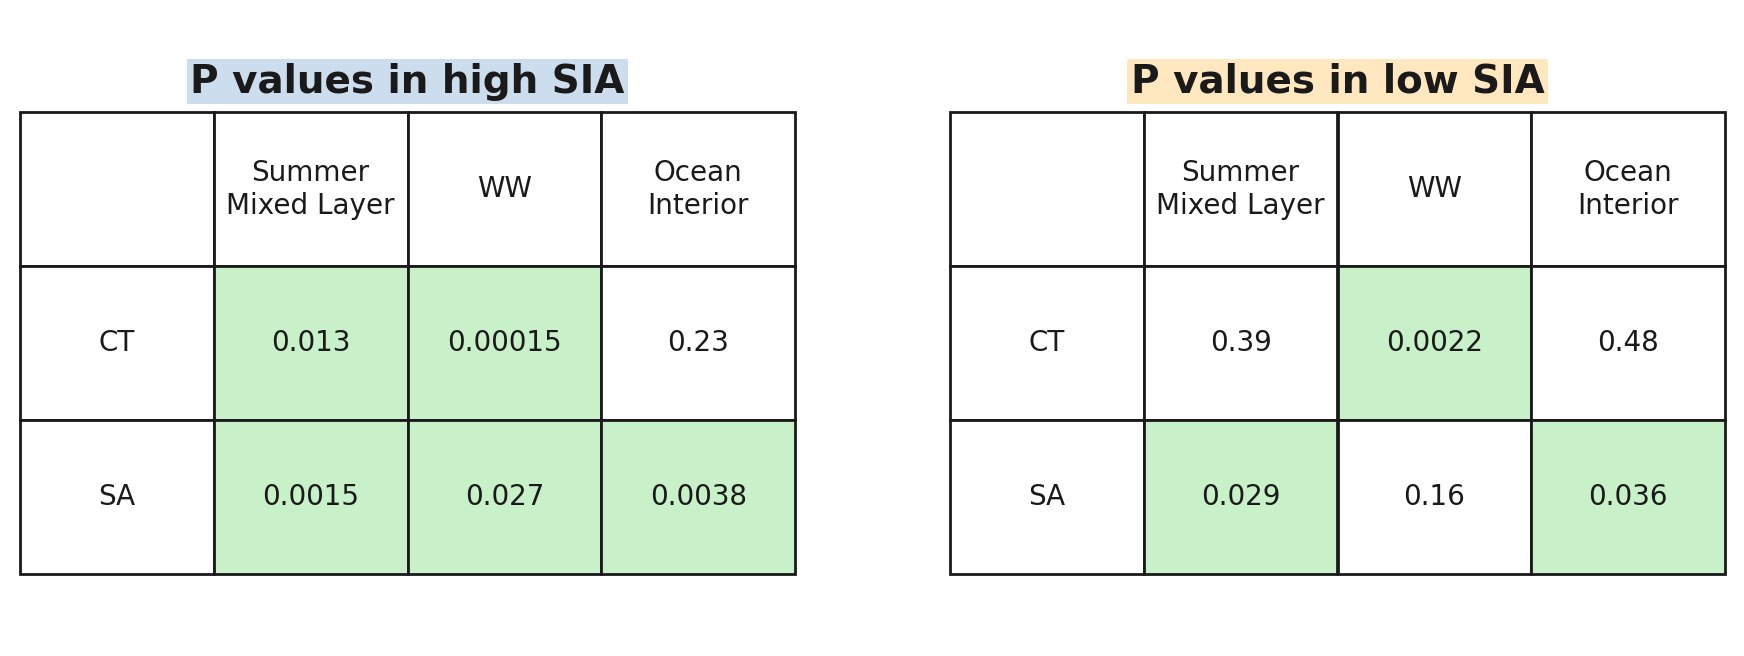

In [100]:
# Collecting high SIA and low SIA p-values
high_sia_pvalues = []
low_sia_pvalues = []

# High SIA
for dataset, t, var_t in zip([sum_ml, ww, oc_int], ['Summer ML', 'WW', 'Ocean Interior'],['CT','SA','N$^2$']):
    row = [var_t]
    for v in ['ctemp', 'asal', 'n2']:
        ols = check_stats(dataset[v + '_anm'][:idx], v, print_stats=0, return_ols=1)
        row.append(f"{ols.pvalue:.2g}")
    high_sia_pvalues.append(row)

# Low SIA
for dataset, t, var_t in zip([sum_ml, ww, oc_int], ['Summer ML', 'WW', 'Ocean Interior'],['CT','SA','N$^2$']):
    row = [var_t]
    for v in ['ctemp', 'asal', 'n2']:
        ols = check_stats(dataset[v + '_anm'][idx:], v, print_stats=0, return_ols=1)
        row.append(f"{ols.pvalue:.2g}")
    low_sia_pvalues.append(row)

# Example data formatting
high_sia_data = high_sia_pvalues  # List of lists for High SIA table
low_sia_data = low_sia_pvalues    # List of lists for Low SIA table

# Plot the tables
fig, axes = plt.subplots(1, 2, figsize=(11, 4), dpi=200)
create_sia_tables(fig, axes, high_sia_data[:2], low_sia_data[:2])
plt.show()